In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer

In [2]:
def outlier_mean(df_x, df_y, class_label):
    return df_x[df_y == class_label].mean()

def impute_outliers(df_x, df_y):
    threshold = 3
    z_scores = np.abs(zscore(df_x))
    outliers_indices = np.where(z_scores > threshold)[0]
    df_x_imputed = df_x.copy()
    
    for idx in np.unique(outliers_indices):
        class_label = df_y[idx]
        imputed_values = outlier_mean(df_x, df_y, class_label)
        for col in df_x.columns:
            df_x_imputed.at[idx, col] = np.array(imputed_values[col]).astype(df_x[col].dtype)
    
    return df_x_imputed

In [8]:
file_path = "./input/genres_v2.csv"
df = pd.read_csv(file_path, low_memory=False)

# 불필요한 feature 제거
df = df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'song_name', 'Unnamed: 0', 'title', 'key', 'mode', 'time_signature'], axis=1)

df_y = df['genre']
df_x = df.drop(['genre'], axis=1)
features = list(df_x.columns)

# Underground Rap, Pop 클래스 제거
mask = ~df_y.isin(['Underground Rap', 'Pop'])
df_y = df_y[mask]
df_x = df_x.loc[mask]
df_y = df_y.reset_index(drop=True)
df_x = df_x.reset_index(drop=True)

df_x = impute_outliers(df_x, df_y)

standard_scaler = StandardScaler()
robust_scaler = RobustScaler()
quantile_scaler = QuantileTransformer(output_distribution='normal')
df_x = pd.DataFrame(robust_scaler.fit_transform(df_x), columns=df_x.columns)

label_encoder = LabelEncoder()
df_y_encoded = label_encoder.fit_transform(df_y)

In [15]:
scalers = {
    "StandardScaler": StandardScaler(),
    "RobustScaler": RobustScaler(),
    "QuantileTransformer": QuantileTransformer(output_distribution='normal'),
    "PowerTransformer": PowerTransformer(method='yeo-johnson') 
}

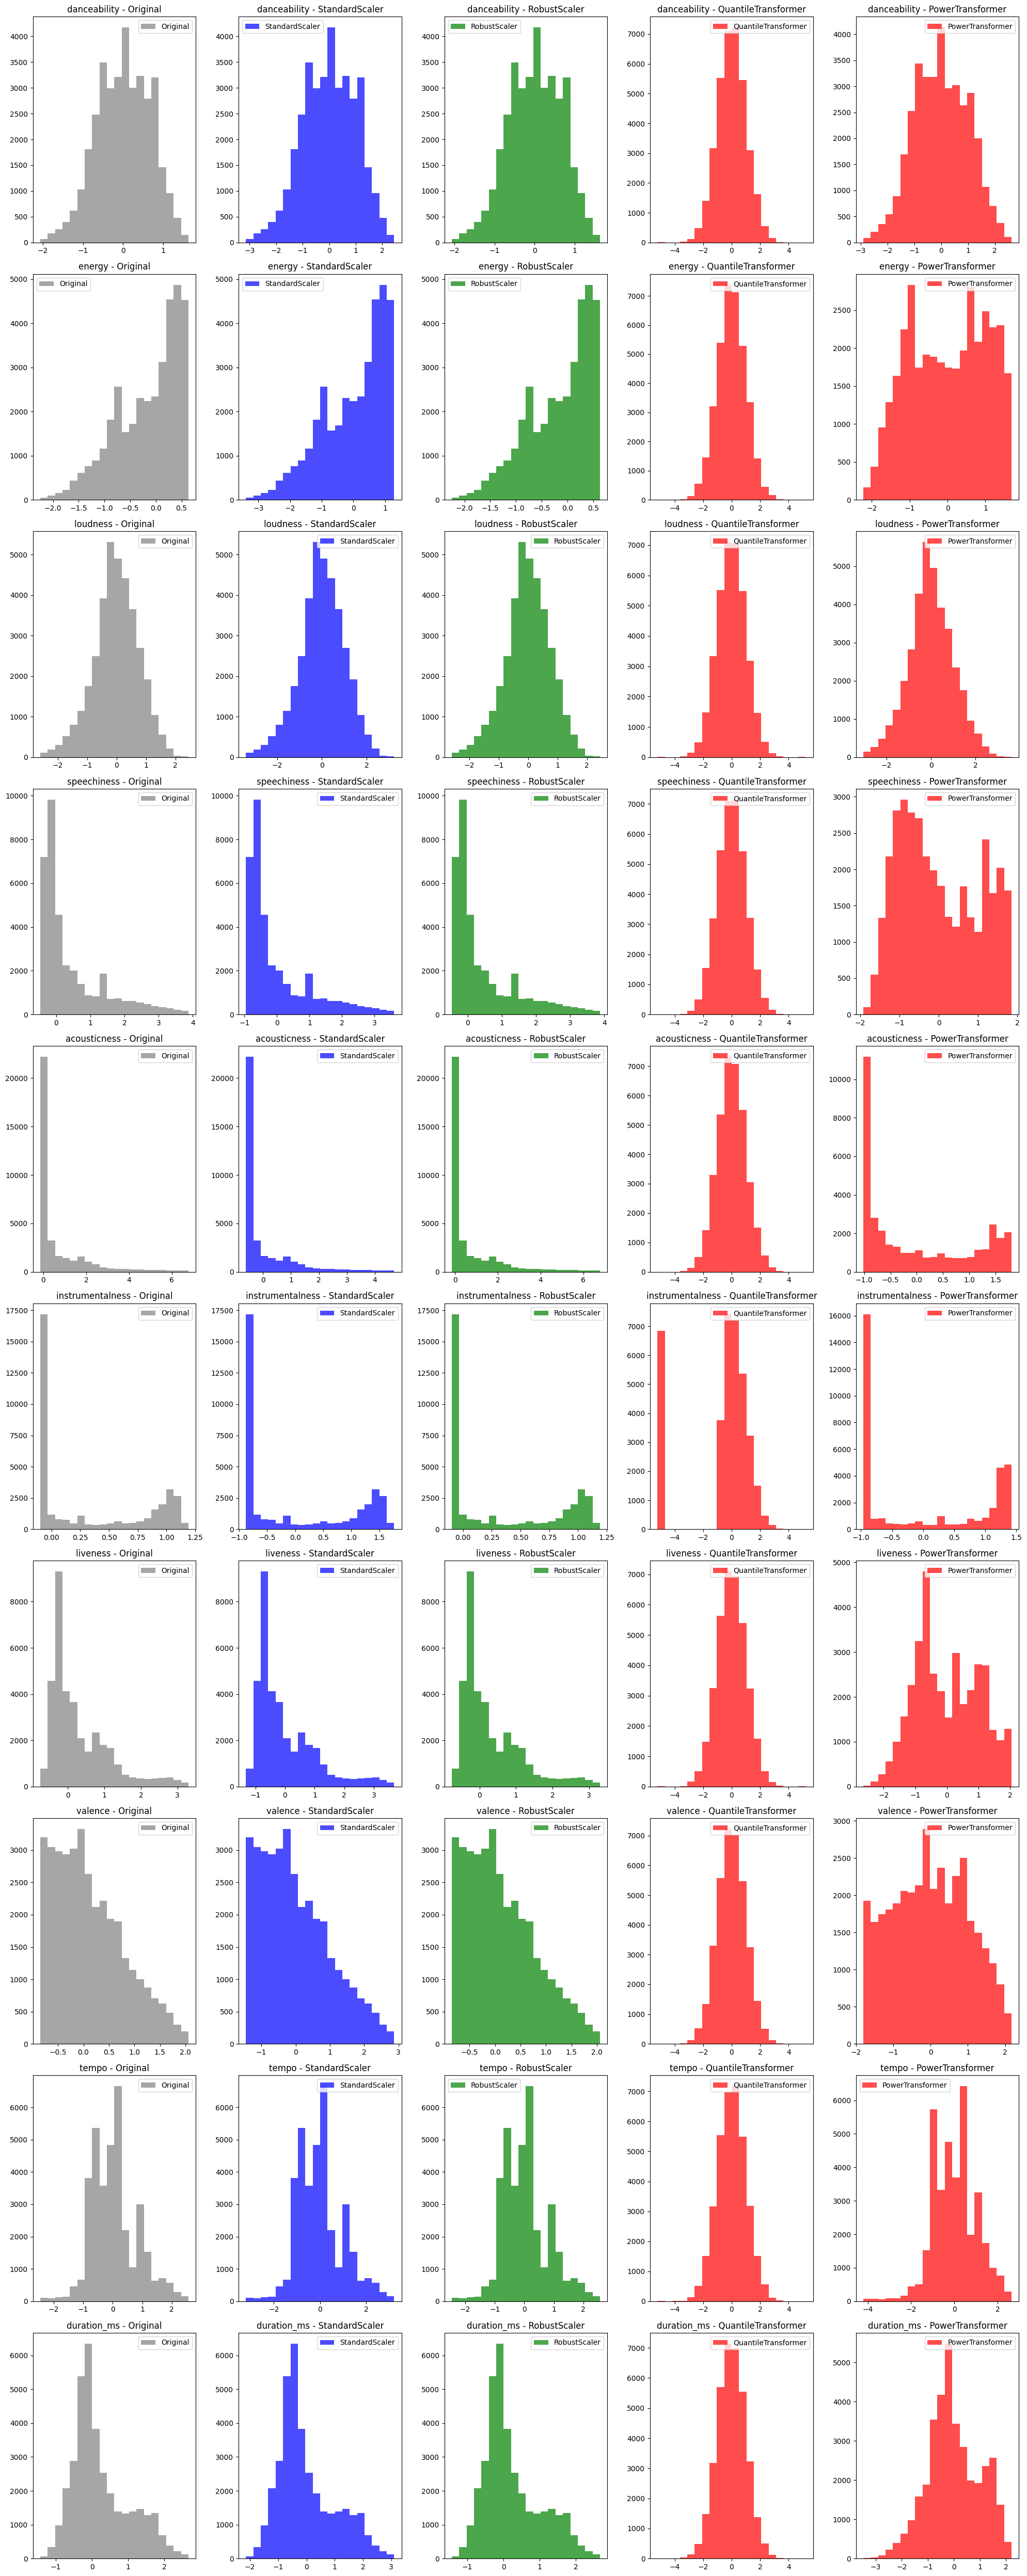

In [17]:
fig, axes = plt.subplots(len(features), 5, figsize=(20, 5 * len(features)))

for i, column in enumerate(features):
    # 원본
    axes[i, 0].hist(df_x[column], bins=20, alpha=0.7, color='gray', label='Original')
    axes[i, 0].set_title(f'{column} - Original')
    axes[i, 0].legend()

    # StandardScaler
    axes[i, 1].hist(scalers["StandardScaler"].fit_transform(df_x[[column]]), bins=20, alpha=0.7, color='blue', label='StandardScaler')
    axes[i, 1].set_title(f'{column} - StandardScaler')
    axes[i, 1].legend()

    # RobustScaler
    axes[i, 2].hist(scalers["RobustScaler"].fit_transform(df_x[[column]]), bins=20, alpha=0.7, color='green', label='RobustScaler')
    axes[i, 2].set_title(f'{column} - RobustScaler')
    axes[i, 2].legend()

    # QuantileTransformer
    axes[i, 3].hist(scalers["QuantileTransformer"].fit_transform(df_x[[column]]), bins=20, alpha=0.7, color='red',label='QuantileTransformer')
    axes[i, 3].set_title(f'{column} - QuantileTransformer')
    axes[i, 3].legend()

    # PowerTransformer
    axes[i, 4].hist(scalers["PowerTransformer"].fit_transform(df_x[[column]]), bins=20, alpha=0.7, color='red',label='PowerTransformer')
    axes[i, 4].set_title(f'{column} - PowerTransformer')
    axes[i, 4].legend()

plt.tight_layout()
plt.show()

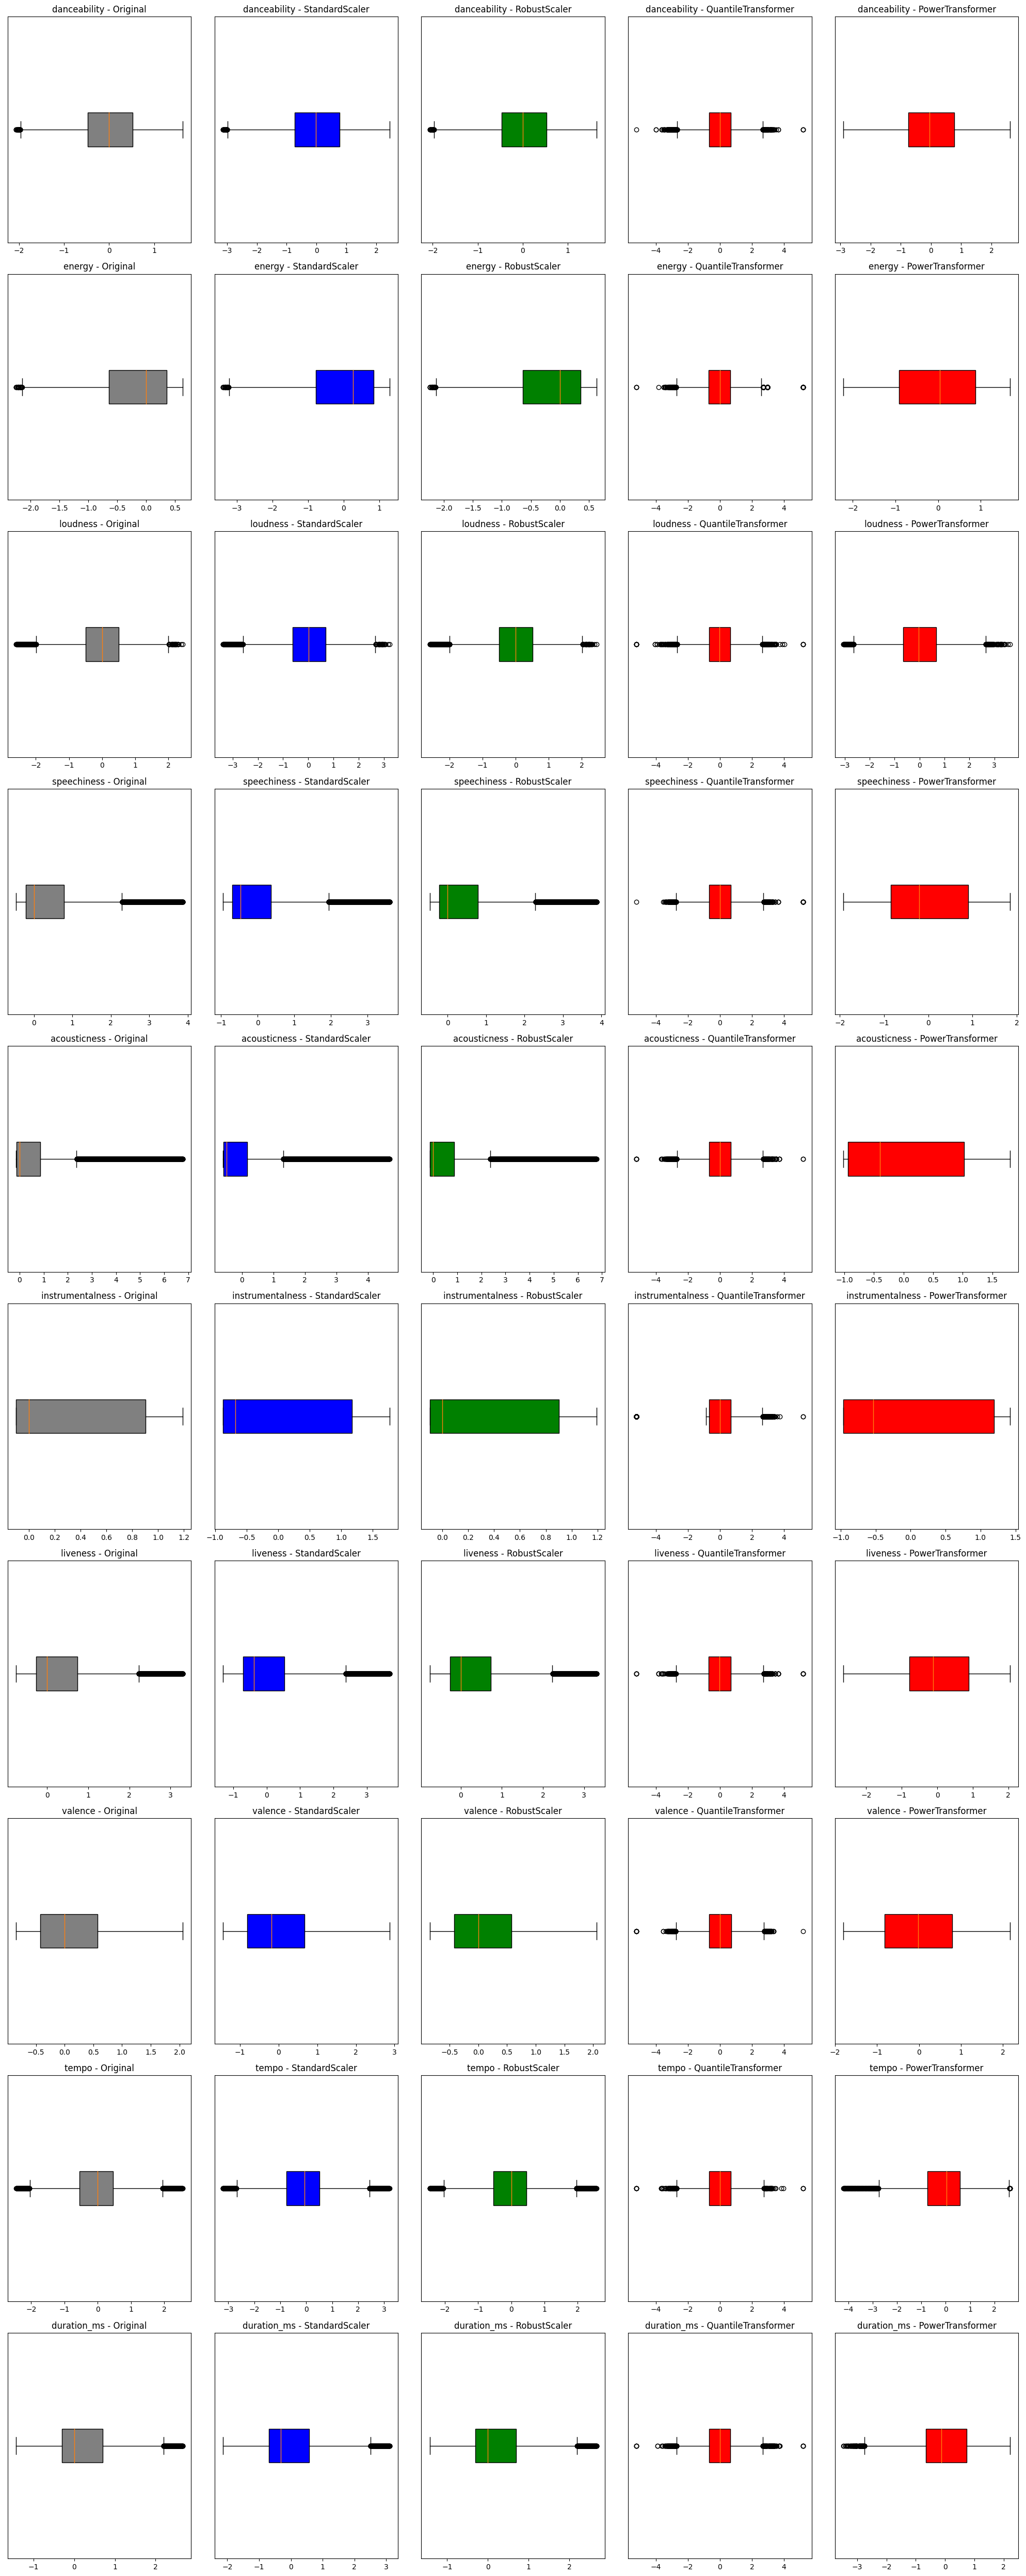

In [18]:
fig, axes = plt.subplots(len(features), 5, figsize=(20, 5 * len(features)))

for i, column in enumerate(features):
    # 원본
    axes[i, 0].boxplot(df_x[column], vert=False, patch_artist=True, boxprops=dict(facecolor='gray', color='black'))
    axes[i, 0].set_title(f'{column} - Original')
    axes[i, 0].set_yticks([])

    # StandardScaler
    scaled_data = scalers["StandardScaler"].fit_transform(df_x[[column]])
    axes[i, 1].boxplot(scaled_data, vert=False, patch_artist=True, boxprops=dict(facecolor='blue', color='black'))
    axes[i, 1].set_title(f'{column} - StandardScaler')
    axes[i, 1].set_yticks([])

    # RobustScaler
    scaled_data = scalers["RobustScaler"].fit_transform(df_x[[column]])
    axes[i, 2].boxplot(scaled_data, vert=False, patch_artist=True, boxprops=dict(facecolor='green', color='black'))
    axes[i, 2].set_title(f'{column} - RobustScaler')
    axes[i, 2].set_yticks([])

    # QuantileTransformer
    scaled_data = scalers["QuantileTransformer"].fit_transform(df_x[[column]])
    axes[i, 3].boxplot(scaled_data, vert=False, patch_artist=True, boxprops=dict(facecolor='red', color='black'))
    axes[i, 3].set_title(f'{column} - QuantileTransformer')
    axes[i, 3].set_yticks([])

    # PowerTransformer
    scaled_data = scalers["PowerTransformer"].fit_transform(df_x[[column]])
    axes[i, 4].boxplot(scaled_data, vert=False, patch_artist=True, boxprops=dict(facecolor='red', color='black'))
    axes[i, 4].set_title(f'{column} - PowerTransformer')
    axes[i, 4].set_yticks([])

plt.tight_layout()
plt.show()

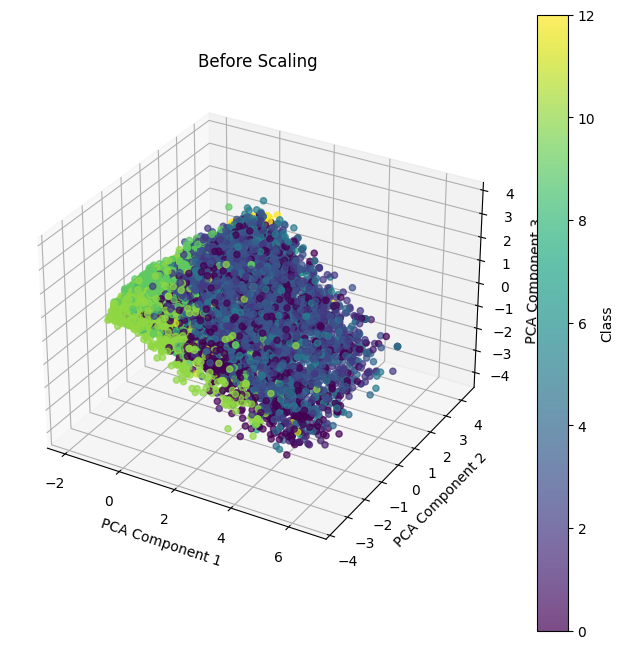

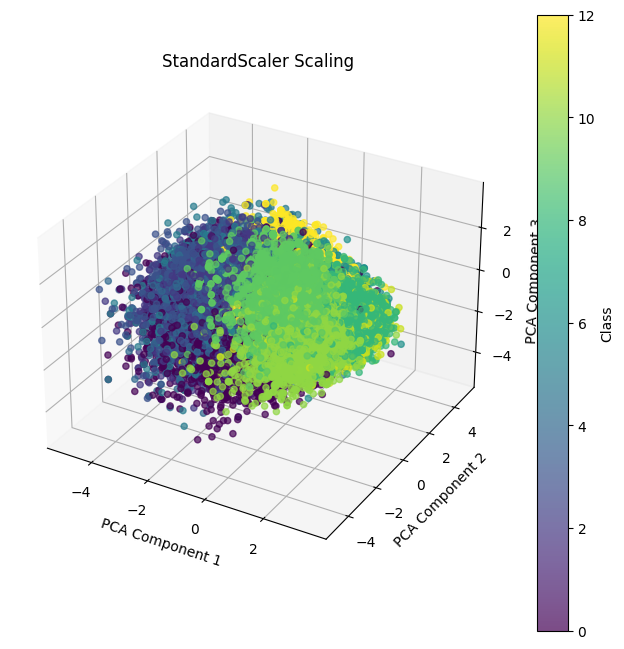

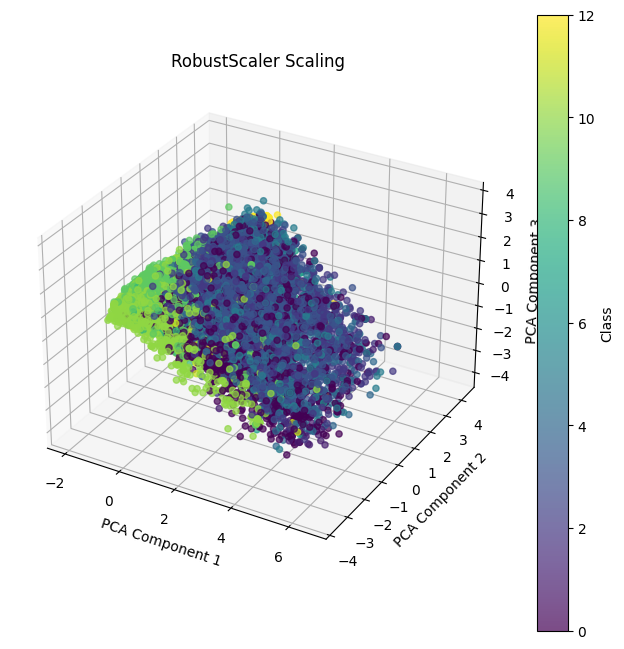

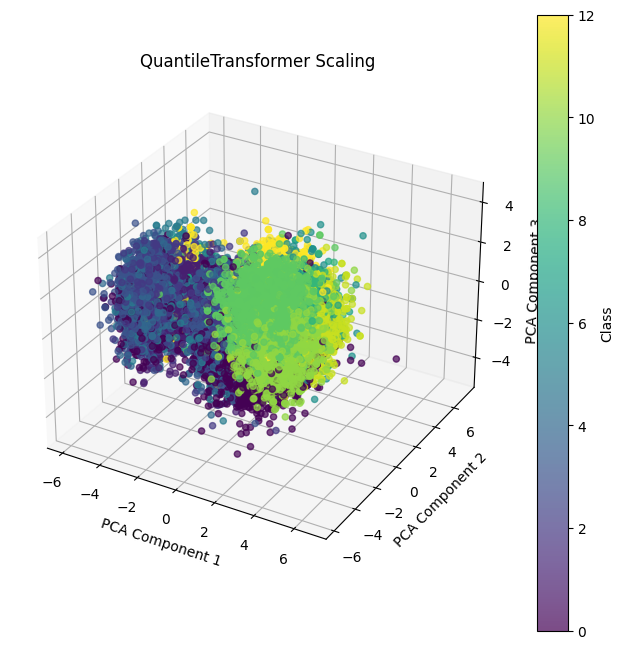

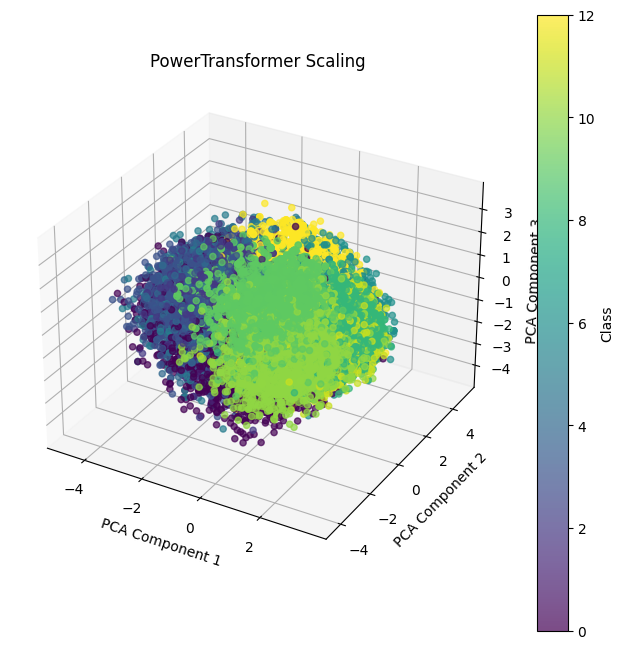

In [28]:
pca = PCA(n_components=3)
X_pca_before = pca.fit_transform(df_x)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_before[:, 0], X_pca_before[:, 1], X_pca_before[:, 2], 
                    c=df_y_encoded, cmap='viridis', alpha=0.7)
ax.set_title('Before Scaling')
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
fig.colorbar(scatter, label='Class')
plt.show()

for scaler in scalers:
    pca = PCA(n_components=3)
    X_scaled = scalers[scaler].fit_transform(df_x)

    X_pca_after = pca.fit_transform(X_scaled)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_pca_after[:, 0], X_pca_after[:, 1], X_pca_after[:, 2], 
                        c=df_y_encoded, cmap='viridis', alpha=0.7)
    ax.set_title(f'{scaler} Scaling')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    fig.colorbar(scatter, label='Class')
    plt.show()